# Developer Tutorial: Using Connectors to interrogate a database

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kghamilton89/MOSTLYAI-challenge/blob/main/developer-tutorial/notebook.ipynb)

The goal of this notebook is to walk through the process by which you are able to use [Connectors](https://mostly.ai/docs/connectors) to establish a connection to a database, generate synthetic data using the [Synthetic Data SDK](https://github.com/mostly-ai/mostlyai/tree/main), and perform basic interrogation and anaysis of the source and destination datasets.

## Process

This notebook guides you through the following actions:
1. Spin up a locally running MariaDB database and seed it with demo data.
2. Use the Synthentic Data SDK to generate a statistically similar dataset.
3. Perform basic interrogation and analysis using Connectors.

## Prerequisites

This notebook contains all of the configuration files that you need to complete the expected actions, but please ensure that you have at least the following requisite systems available:
- [Docker](https://www.docker.com/products/docker-desktop/)
- [ngrok](https://ngrok.com/)
- [MOSTLY AI](https://app.mostly.ai/)

## Architecture

You are going to create a locally running Docker Container image of a fully seeded MariaDB database, generate a synthetic replica of the dataset in order to ensure that potentially private data is protected from exposure, and use SQL and standard visualization libraries to inspect the two datasets together.

![developer tutorial architecture](../images/architecture.jpg)

## Contents

1. [Building a local database](#building-a-local-database)
2. [Connecting to MOSTLY AI](#connecting-to-mostlyai)
3. [Generating synthetic data](#generating-synthetic-data)
4. [Performing analysis and interrogation](#performing-analysis-and-interrogation)
    - [Data Sense Checks](#data-sense-checks)
      - [Count Rows](#count-rows)
      - [Total Purchases](#total-purchases)
    - [Visualze Data](#visualize-data)
      - [Purchases over time by gender and source](#purchases-over-time-by-gender-and-source)
      - [Purchases over time by zone and source](#purchases-over-time-by-zone-and-source)
      - [Purchases over time by age category and source](#purchases-over-time-by-age-category-and-source)
5. [Conclusions](#conclusions)

## Outcomes

By the end of this walkthrough, you will have a strong understanding of using MOSTLY AI tools to setup a local database connection using Connectors, generating synthetic data using the Synthetic Generation SDK, and performing basic interrogation and analysis of the destination dataset.

-----

## Building a local database

This walkthorugh uses the [CDNOW dataset](https://mostly.ai/docs/datasets#cdnow-dataset), which contains the entire purchase history up to the end of June 1998 of 23,570 customers who made their first-ever purchase at CDNOW in the first quarter of 1997. It is available locally at `./CDNOW_dataset`. To make this analysis more efficient, we'll use a small segment of that data.

To get started, make sure that you are working in the appropriate directory:

```bash
cd ./developer-tutorial
```

Create and activate a virtural environment:
```bash
python3 -m venv venv
source venv/bin/activate
```

Create a `.env` file to store your MOSTLY AI API key, which can be accessed [here](https://app.mostly.ai/settings/api-keys):
```bash
touch .env
```

Save your MOSTLY AI API key as a variable in `.env`:
```bash
MOSTLYAI_API_KEY=mostly-XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
```

In [1]:
# install the requisite libraries for this tutorial
%pip install mostlyai python-dotenv seaborn -qqq

Note: you may need to restart the kernel to use updated packages.


The required seed data and database configuration is available in this repository. If Docker and MariaDB are properly set up, you can just run the following terminal command to launch a new image with the required data:
```bash
docker compose up
```

The `docker-compose.yml` file creates two databases local: `testdb` and `synth-testdb` which is an empty clone of `testdb` where you will write generated data.

In [ ]:
# import necessary libraries
from dotenv import load_dotenv
import os
from mostlyai.sdk import MostlyAI

# configure sdk
load_dotenv()
api_key = os.getenv("MOSTLYAI_API_KEY")
mostly = MostlyAI(local=False, api_key=api_key)

-----

## Connecting to MOSTLY AI

Now that our MariaDB image is running and we've initialized the Synthetic Data SDK cloud client, we need to expose our local TCP port so that it can be accessed by MOSTLY AI.

The specifics of this process are covered in greater detail [here](https://mostly.ai/docs/connectors/use/local-db). Once you have set up ngrok, you can expose the required port using the following command in the terminal:
```bash
ngrok tcp 3306
```

In the output, use the `Forwarding` parameter to update the template configuration:
```bash
Forwarding tcp://X.tcp.eu.ngrok.io:XXXXX -> localhost:3306
```

The configuration below creates two Connectors, one which reads data and one which writes data. See more about Connector access types [here](https://mostly.ai/docs/connectors/use/access-types).

In [ ]:
# initialize source (READ_DATA) and destination (WRITE_DATA) connectors

src_c = mostly.connect(config={
    "name": "Local MariaDB Source",
    "type": "MARIADB",
    "access_type": "READ_DATA",           # enable connector to read data
    "config": {
        "host": "X.tcp.eu.ngrok.io",      # update with your actual ngrok host
        "port": 11111,                    # update with your actual ngrok port
        "username": "user",
        "database": "testdb"
    },
    "secrets": {
        "password": "password"
    }
})

dest_c = mostly.connect(config={
    "name": "Local MariaDB Destination",
    "type": "MARIADB",
    "access_type": "WRITE_DATA",          # enable connector to write data
    "config": {
        "host": "X.tcp.eu.ngrok.io",      # update with your actual ngrok host
        "port": 11111,                    # update with your actual ngrok port
        "username": "user",
        "database": "testdb"
    },
    "secrets": {
        "password": "password"
    }
})

Because we're using the MOSTLY AI client, your Connectors are also visible in the MOSTLY AI UI on the [Connectors tab](https://app.mostly.ai/d/connectors).

![connectors tab](../images/connectors.jpg)


----

## Generating synthetic data

Now that you've spun up a local MariaDB image, seeded it with a subset of the CDNOW dataset, and connected to the MOSTLY AI Synthetic Data SDK, you're ready to train a synthetic generator and create some synthetic data.

For more information about configuring a custom synethetic data generator for your own use case, please see the documentation [here](https://mostly.ai/docs/generators).

In [ ]:
# train a synthetic data generator
g = mostly.train(config={
    'name': 'CDNOW_synthetic_gen',
    'tables': [
        {
            'name': 'Customers',
            'source_connector_id': src_c.id,
            'location': 'testdb.Customers',
            'primary_key': 'id',             # define relationship between tables
        },
        {
            'name': 'Purchases',
            'source_connector_id': src_c.id,
            'location': 'testdb.Purchases',
            'foreign_keys': [                # define relationship between tables
            {'column': 'users_id', 'referenced_table': 'Customers', 'is_context': True},
        ],

        },
    ],
}, start=True, wait=False)

# output a synthetic data qa report
g.reports(display=True)

The `reports(display=True)` argument outputs a detailed QA report of the trained generator model. This report contains both univariate and multivariate analysis, as well as accuracy reports and other statistical information about the resultant dataset. You can also evaluate the results of the generator in the app dashboard, as descibed by [the documentation](https://mostly.ai/docs/synthetic-datasets/evaluate-quality).

![model report](../images/models-report.jpg)

In [ ]:
# launch generator and create synthetic dataset
sd = mostly.generate(g, config={
    "name": "CDNOW_synthetic_dataset",
    "delivery": {
        "destination_connector_id": dest_c.id,
        "location": "synth_testdb",
        "overwrite_tables": True
    }
})

The output of the `generate()` function includes a live progress report:

![progress report](../images/progress.jpg)

And you can also view the results of your synthetic data generation job in the MOSTLY AI UI on the [Generators tab](https://app.mostly.ai/d/generators).

![generators tab](../images/generator.jpg)


----

# Performing analysis and interrogation

Now that we've created a whole new synthetic dataset using the Synethetic Data SDK, we're ready to perform some basic analysis. If you'd like, try using the [MOSTLY AI Assistant](https://app.mostly.ai/d/assistant) to use plain-English prompts to query your dataset as well! This workflow is covered in this short [Explainer Video](https://drive.google.com/file/d/190RHLvs_EzH2dGX4CkZhsWxfVOHB4kd-/view?usp=drive_link).

### Data sense checks

The first thing to do once you've generated synthetic data is to perform some basic sense checks on the output. This ensures that your generator configuration (including primary / foreign key relationships) are working as expected.

#### Count Rows

Use the following SQL queries to print out some basic JOIN operations. It is expected to see non-zero values for all queries, as seen in the output.

In [ ]:
# get the id from our read-only connector
connector = mostly.connectors.get(src_c.id)

# join on primary / foreign key relationship for real data
real_join_check = """
SELECT COUNT(*) AS matched_rows
FROM testdb.Customers c
JOIN testdb.Purchases p ON c.id = p.users_id
"""

# join on primary / foreign key relationship for synthetic data
synth_join_check = """
SELECT COUNT(*) AS matched_rows
FROM synth_testdb.Customers c
JOIN synth_testdb.Purchases p ON c.id = p.users_id
"""

# execute the queries using the connector
real_count = connector.query(real_join_check)
synth_count = connector.query(synth_join_check)

# print the results
print("Real matched rows:", real_count.iloc[0]["matched_rows"])
print("Synthetic matched rows:", synth_count.iloc[0]["matched_rows"])


Real matched rows: 2500
Synthetic matched rows: 2737


#### Total Purchases

It also makes sense to double check that purchase data has been successfully sythesized. Use the following cells to print out total purchase amounts. In the next step, we'll visualize the data across the observed time window.

In [ ]:
# build our sql queries to sense check total purchases
real_purchase_summary = connector.query("""
SELECT
    COUNT(*) AS total_purchases,
    SUM(amt) AS total_amount,
    AVG(amt) AS avg_amount
FROM testdb.Purchases
""")

synth_purchase_summary = connector.query("""
SELECT
    COUNT(*) AS total_purchases,
    SUM(amt) AS total_amount,
    AVG(amt) AS avg_amount
FROM synth_testdb.Purchases
""")

# print the results
print("Real Purchases Summary:\n", real_purchase_summary)
print("Synthetic Purchases Summary:\n", synth_purchase_summary)


Real Purchases Summary:
    total_purchases  total_amount  avg_amount
0             2500      90975.37   36.390148
Synthetic Purchases Summary:
    total_purchases  total_amount  avg_amount
0             2737      92889.97   33.938608


### Visualize data

Now that you've confirmed your data has been successfully generated, let's create a few visualizations to compare the source and generated datasets. We'll use the [Seaborn library](https://seaborn.pydata.org/) to build these visualizations, but you can use another library if you prefer.

#### Purchases over time by gender and source

In [ ]:
# import visualization libs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# define our sql queries for each domain
real_df = connector.query("""
    SELECT
        DATE_FORMAT(p.date, '%Y-%m') AS month,
        c.gender,
        COUNT(*) AS num_purchases
    FROM testdb.Customers c
    JOIN testdb.Purchases p ON c.id = p.users_id
    GROUP BY month, c.gender
    ORDER BY month
""")

synth_df = connector.query("""
    SELECT
        DATE_FORMAT(p.date, '%Y-%m') AS month,
        c.gender,
        COUNT(*) AS num_purchases
    FROM synth_testdb.Customers c
    JOIN synth_testdb.Purchases p ON c.id = p.users_id
    GROUP BY month, c.gender
    ORDER BY month
""")

In [ ]:
# append source suffix to dataframes
real_df['group'] = real_df['gender'].map({'M': 'Male', 'F': 'Female'}) + ' - Real'
synth_df['group'] = synth_df['gender'].map({'M': 'Male', 'F': 'Female'}) + ' - Synthetic'

# convert month column to datetime for time series visualization
real_df['month'] = pd.to_datetime(real_df['month'])
synth_df['month'] = pd.to_datetime(synth_df['month'])

# join dataframes
plot_df = pd.concat([real_df, synth_df], ignore_index=True)

# define a nice looking custom color palette
custom_palette = {
    'Male - Real': '#006400',
    'Male - Synthetic': '#90ee90',
    'Female - Real': '#00008b',
    'Female - Synthetic': '#87cefa'
}

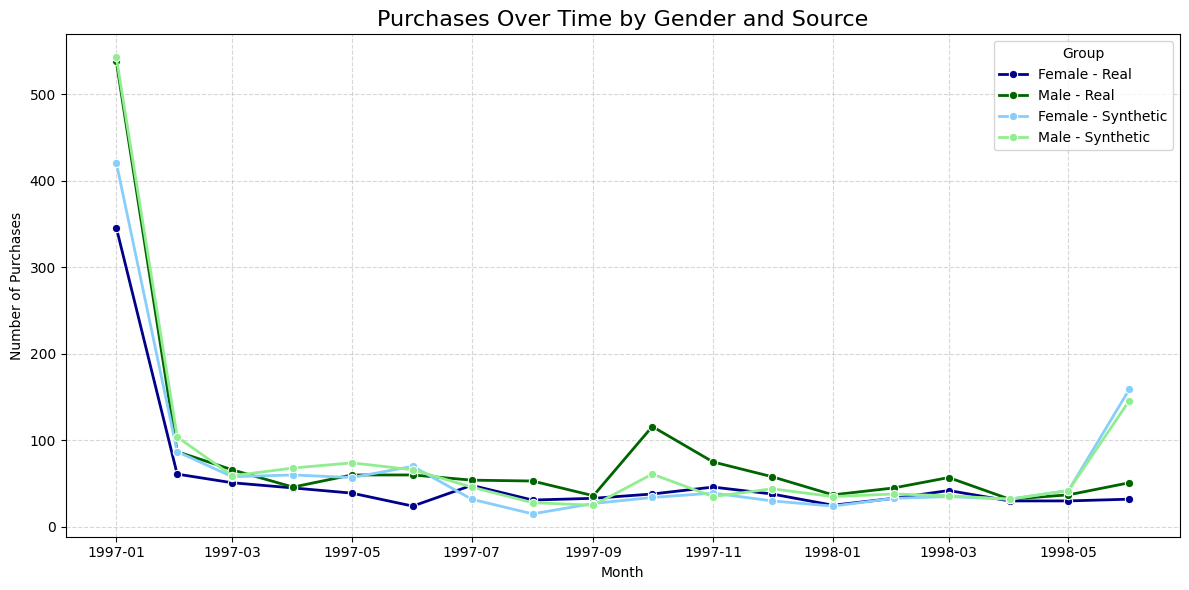

In [ ]:
# define the configuration of our visualization
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=plot_df,
    x='month',
    y='num_purchases',
    hue='group',
    palette=custom_palette,
    linewidth=2,
    marker='o'
)

plt.title("Purchases Over Time by Gender and Source", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Number of Purchases")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Group')
plt.tight_layout()
plt.show()


#### Purchases over time by zone and source

In [ ]:
# define our sql queries for each domain
real_zone_df = connector.query("""
    SELECT
        DATE_FORMAT(p.date, '%Y-%m') AS month,
        c.zone,
        COUNT(*) AS num_purchases
    FROM testdb.Customers c
    JOIN testdb.Purchases p ON c.id = p.users_id
    GROUP BY month, c.zone
    ORDER BY month
""")

synth_zone_df = connector.query("""
    SELECT
        DATE_FORMAT(p.date, '%Y-%m') AS month,
        c.zone,
        COUNT(*) AS num_purchases
    FROM synth_testdb.Customers c
    JOIN synth_testdb.Purchases p ON c.id = p.users_id
    GROUP BY month, c.zone
    ORDER BY month
""")


In [ ]:
# append source suffix to dataframes
real_zone_df['group'] = real_zone_df['zone'] + ' - Real'
synth_zone_df['group'] = synth_zone_df['zone'] + ' - Synthetic'

# convert month column to datetime for time series visualization
real_zone_df['month'] = pd.to_datetime(real_zone_df['month'])
synth_zone_df['month'] = pd.to_datetime(synth_zone_df['month'])

# join our dataframes
zone_plot_df = pd.concat([real_zone_df, synth_zone_df], ignore_index=True)


In [ ]:
# define a nice looking custom color palette
zone_colors = {
    'Pacific - Real': '#1b9e77',
    'Pacific - Synthetic': '#a6dba0',
    'Mountain - Real': '#d95f02',
    'Mountain - Synthetic': '#fdb863',
    'Central - Real': '#7570b3',
    'Central - Synthetic': '#b3cde3',
    'Eastern - Real': '#e7298a',
    'Eastern - Synthetic': '#fbb4ae'
}


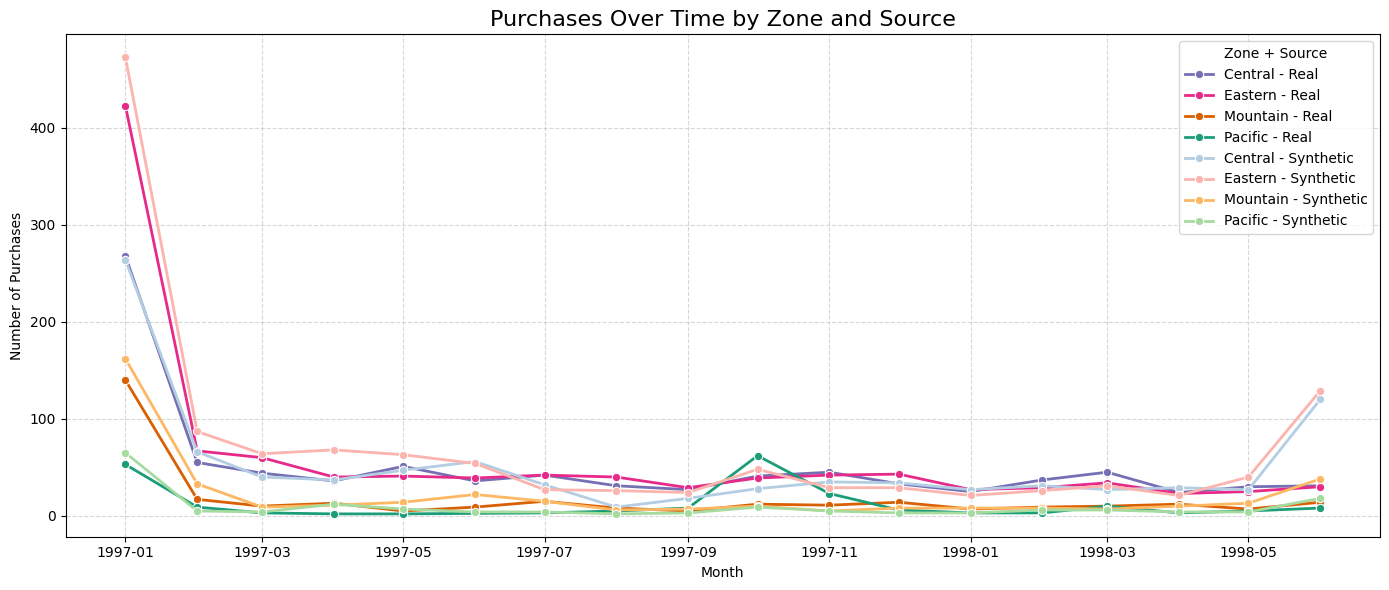

In [ ]:
# define the configuration of our visualization
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=zone_plot_df,
    x='month',
    y='num_purchases',
    hue='group',
    palette=zone_colors,
    linewidth=2,
    marker='o'
)
plt.title("Purchases Over Time by Zone and Source", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Number of Purchases")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Zone + Source')
plt.tight_layout()
plt.show()


#### Purchases over time by age category and source

In [ ]:
# define our sql queries for each domain
real_age_df = connector.query("""
    SELECT
        DATE_FORMAT(p.date, '%Y-%m') AS month,
        c.age_category,
        COUNT(*) AS num_purchases
    FROM testdb.Customers c
    JOIN testdb.Purchases p ON c.id = p.users_id
    GROUP BY month, c.age_category
    ORDER BY month
""")

synth_age_df = connector.query("""
    SELECT
        DATE_FORMAT(p.date, '%Y-%m') AS month,
        c.age_category,
        COUNT(*) AS num_purchases
    FROM synth_testdb.Customers c
    JOIN synth_testdb.Purchases p ON c.id = p.users_id
    GROUP BY month, c.age_category
    ORDER BY month
""")


In [ ]:
# append source suffix to dataframes
real_age_df['group'] = real_age_df['age_category'] + ' - Real'
synth_age_df['group'] = synth_age_df['age_category'] + ' - Synthetic'

# convert month column to datetime for time series visualization
real_age_df['month'] = pd.to_datetime(real_age_df['month'])
synth_age_df['month'] = pd.to_datetime(synth_age_df['month'])

# join dataframes
age_plot_df = pd.concat([real_age_df, synth_age_df], ignore_index=True)


In [ ]:
# define a nice looking custom color palette
age_colors = {
    'young - Real': '#1f78b4',
    'young - Synthetic': '#a6cee3',
    'medium - Real': '#33a02c',
    'medium - Synthetic': '#b2df8a',
    'old - Real': '#ff7f00',
    'old - Synthetic': '#fdbf6f',
    ' - Real': '#999999',
    ' - Synthetic': '#cccccc'
}


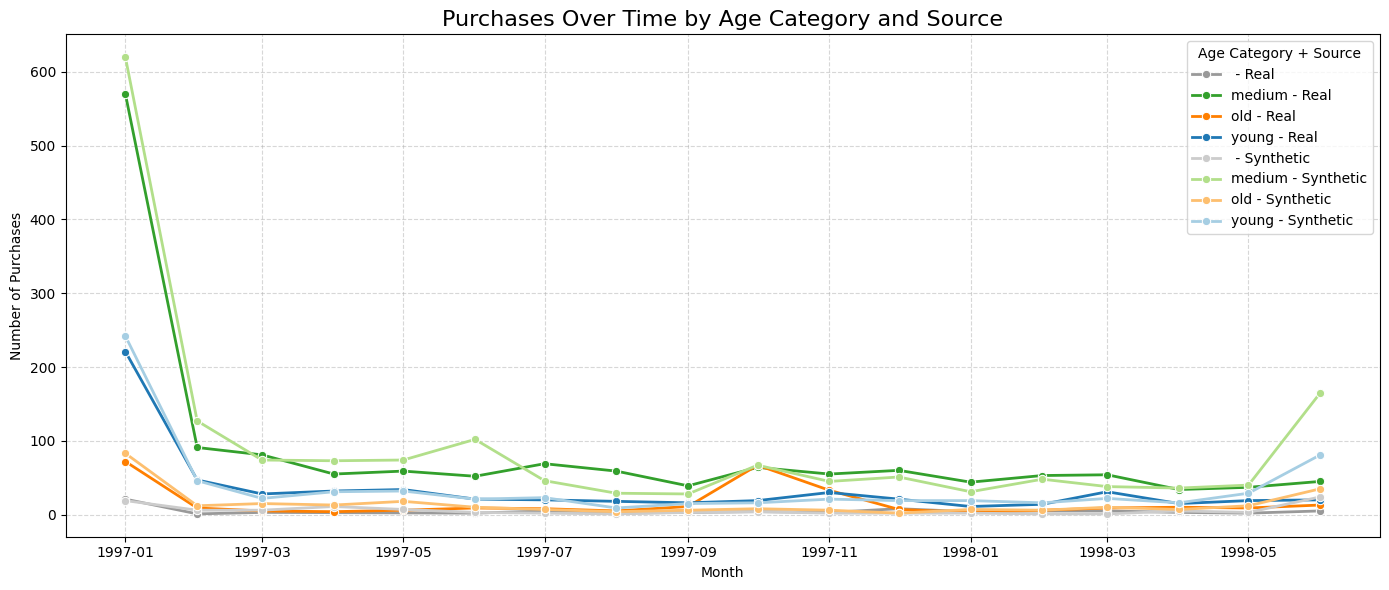

In [ ]:
# define the configuration of our visualization
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=age_plot_df,
    x='month',
    y='num_purchases',
    hue='group',
    palette=age_colors,
    linewidth=2,
    marker='o'
)
plt.title("Purchases Over Time by Age Category and Source", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Number of Purchases")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Age Category + Source')
plt.tight_layout()
plt.show()


## Conclusions

That's it! In this tutorial, we've spun up a local MariaDB Docker image, seeded it with data, generated synthetic data using the MOSTLY AI Synthetic Data SDK based on the underlying CDNOW data, and performed some basic interrogation of the dataset using SQL and Seaborn visualizations.

You can adapt this notebook to your own use case and create all kinds of useful synthetic datasets in order to perform meaningful analyses while keeping PII and other private data private.

Let's try to interrogate the data bit further using the [MOSTLY AI Assistant](https://drive.google.com/file/d/190RHLvs_EzH2dGX4CkZhsWxfVOHB4kd-/view?usp=drive_link) next!